The validation scheme is based on [seq2seq-rnn-with-gru](https://www.kaggle.com/brandenkmurray/seq2seq-rnn-with-gru/output), and cleaned data is from [data-without-drift](https://www.kaggle.com/cdeotte/data-without-drift) and Kalman filter is from [https://www.kaggle.com/teejmahal20/single-model-lgbm-kalman-filter](single-model-lgbm-kalman-filter) and the added feature is from [wavenet-with-1-more-feature](wavenet-with-1-more-feature). I also used ragnar's data in this version [clean-kalman](https://www.kaggle.com/ragnar123/clean-kalman). The Wavenet is based on [https://github.com/philipperemy/keras-tcn](https://github.com/philipperemy/keras-tcn), [https://github.com/peustr/wavenet](https://github.com/peustr/wavenet) and [https://github.com/basveeling/wavenet](https://github.com/basveeling/wavenet) and also [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm). If any refrence is not mentioned it was not intentional, please add them in comments.

Previous versions were mainly based on [https://www.kaggle.com/wimwim/wavenet-lstm](https://www.kaggle.com/wimwim/wavenet-lstm)  

In [0]:
!pip install --no-warn-conflicts -q tensorflow-addons

In [0]:
from tensorflow.keras.layers import (TimeDistributed, Dropout, BatchNormalization, Flatten, Convolution1D, Activation, Input, Dense, LSTM, Lambda, Bidirectional,
                                     Add, AveragePooling1D, Multiply, GRU, GRUCell, LSTMCell, SimpleRNNCell, SimpleRNN, TimeDistributed, RNN,
                                     RepeatVector, Conv1D, MaxPooling1D, Concatenate, GlobalAveragePooling1D, UpSampling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, mean_squared_error
# from tensorflow.keras.experimental import export_saved_model, load_from_saved_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras import losses, models, optimizers
from tensorflow.keras import backend as K
import tensorflow as tf
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict
from sklearn.metrics import f1_score, cohen_kappa_score, mean_squared_error
from logging import getLogger, Formatter, StreamHandler, FileHandler, INFO, DEBUG, NOTSET
from sklearn.model_selection import KFold, GroupKFold
from tqdm import tqdm_notebook as tqdm
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import display
from sklearn import preprocessing
import tensorflow_addons as tfa
import scipy.stats as stats
import random as rn
import pandas as pd
import numpy as np
import scipy as sp
import itertools
import warnings
import time
import pywt
import os
import gc

from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [2]:
import os, sys
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

path = "/content/drive/My Drive"

os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Smart and Connected Everything_LTO2015_April 2 2014.pptx',
 '无标题绘图.gdraw',
 'Smart and Connected Everything_LTO2015_April 2 2014.pptx.gslides',
 'Class mytest.gdoc',
 '简历.gdoc',
 '2018.10.14.pdf',
 'Learning notebook',
 'Verification',
 'da6ca21e-d8e3-4f08-816e-da2ac02f192f.pdf',
 'Colab Notebooks',
 'Course1FinalProject',
 'CARLA',
 'resulting_data.csv.gsheet',
 'Patents.gdoc',
 'Coursera_Self-Driving Cars_Toronto',
 'Python programming',
 'Tensorflow_CS20SI',
 'Paper reading',
 '无标题文档 (2).gdoc',
 'forms for H4.pdf',
 'forms for H4.gdoc',
 '无标题文档 (1).gdoc',
 'SVO.gdoc',
 '无标题文档.gdoc',
 'YuanLin_CV_update2.pdf',
 'YuanLin_CV.pdf',
 'CV.gdoc',
 '博士论文_HC.doc',
 '博士论文_HC.pdf',
 'models',
 'CenterNetMask2-Aug-DrLr.ipynb',
 'predictions-b4augmaskonelr40th-0.85.csv',
 'setup.ipynb',
 'CES2020 - VE Tech Forum.key',
 'log-64-1e-3-aug.csv',
 'log-1e-4-128-aug.csv',
 'log.csv',
 'tmp',
 'ion_switch',
 'predictions',
 'CSDN',
 'Untitled',
 'wavenet-es.png']

In [0]:
# sys.path.append('ion_switch/keras-one-cycle')
# # os.listdir(patholr)
# from clr import OneCycleLR

In [0]:
# PATH = '/kaggle/input/'
# PATH = '/Users/helen/Desktop/Data/'
PATH = 'ion_switch/'
outdir = Path(PATH+'res')
if not os.path.exists(outdir):
    os.mkdir(outdir)
outdir = Path(PATH+'res/wavenet-clr-res')
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [0]:
EPOCHS=2
NNBATCHSIZE=20
BATCHSIZE = 4000
SEED = 321
SELECT = True
SPLITS = 5
LR = 0.001
fe_config = [
    (True, BATCHSIZE),
]

COMPETITION = 'ION-Switching'
logger = getLogger(COMPETITION)
LOGFORMAT = '%(asctime)s %(levelname)s %(message)s'
MODELNAME = 'WaveNet-ES-CLR'

VERSION = '{}_len{}_lr{}'.format(MODELNAME, BATCHSIZE, LR)

In [0]:

@contextmanager
def timer(name : Text):
    t0 = time.time()
    yield
    logger.info(f'[{name}] done in {time.time() - t0:.0f} s')

In [0]:
from datetime import datetime
def init_logger():

    handler = StreamHandler()
    handler.setLevel(INFO)
    handler.setFormatter(Formatter(LOGFORMAT))
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H:%M:%S.%f")
    fh_handler = FileHandler(os.path.join(outdir,'{}-len{}-lr{}-{}.log'.format(MODELNAME,BATCHSIZE,LR,timestampStr)))
    fh_handler.setFormatter(Formatter(LOGFORMAT))
    logger.setLevel(INFO)
    logger.addHandler(handler)
    logger.addHandler(fh_handler)
    

In [0]:

def seed_everything(seed : int) -> NoReturn :
    
    rn.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    # os.environ['TF_CUDNN_DETERMINISTIC'] = str(seed) 

seed_everything(SEED)

In [0]:
class CyclicLR(tf.keras.callbacks.Callback):

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2. ** (x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x)) * self.scale_fn(
                self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    # def on_batch_end(self, epoch, logs=None):

    #     logs = logs or {}
    #     self.trn_iterations += 1
    #     self.clr_iterations += 1

    #     K.set_value(self.model.optimizer.lr, self.clr())
    #     print("learning rate- self.model.optimizer.lr: ", self.model.optimizer.lr)
        
    def on_epoch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        K.set_value(self.model.optimizer.lr, self.clr())
        logger.info(f'epoch:{epoch:03d},'+str(K.eval(self.model.optimizer.lr)))

In [0]:
import matplotlib.pyplot as plt

# 写一个LossHistory类，保存训练集的loss和acc
# 当然我也可以完全不这么做，可以直接使用model.fit()方法返回的 history对象去做
'''Callback有6个常用的方法，这里实现其中的四个
    def on_epoch_begin(self, epoch, logs=None):
    def on_epoch_end(self, epoch, logs=None):
    def on_batch_begin(self, batch, logs=None):
    def on_batch_end(self, batch, logs=None):
    def on_train_begin(self, logs=None):
    def on_train_end(self, logs=None):
'''
class LossHistory(Callback):  # 继承自Callback类
 
    '''
    在模型开始的时候定义四个属性，每一个属性都是字典类型，存储相对应的值和epoch
    '''
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    # 在每一个batch结束后记录相应的值
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))
    
    # 在每一个epoch之后记录相应的值
    def on_epoch_end(self, epoch, logs={}):
        trloss, tracc, vloss, vacc = logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')
        self.losses['epoch'].append(trloss)
        self.accuracy['epoch'].append(tracc)
        self.val_loss['epoch'].append(vloss)
        self.val_acc['epoch'].append(vacc)
        logger.info("epoch:{:03d}, train_loss:{:1.5f}, train_acc:{:1.5f}, val_loss:{:1.5f}, val_acc:{:1.5f}".format(epoch, 
                                                                                                                trloss, tracc, vloss, vacc))
 
    def loss_plot(self, loss_type):
        '''
        loss_type：指的是 'epoch'或者是'batch'，分别表示是一个batch之后记录还是一个epoch之后记录
        '''
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig("wavenet-es.png")
        plt.show()

In [0]:

def read_data(base : os.path.abspath) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    train = pd.read_csv(PATH+'clean-kalman/train_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32, 'open_channels':np.int32})
    test  = pd.read_csv(PATH+'clean-kalman/test_clean_kalman.csv', dtype={'time': np.float32, 'signal': np.float32})
    sub  = pd.read_csv(PATH+'liverpool-ion-switching/sample_submission.csv', dtype={'time': np.float32})
    
    return train, test, sub


In [0]:

def batching(df : pd.DataFrame,
             batch_size : int) -> pd.DataFrame :
    
    df['group'] = df.groupby(df.index//batch_size, sort=False)['signal'].agg(['ngroup']).values
    df['group'] = df['group'].astype(np.uint16)
        
    return df


In [0]:

def reduce_mem_usage(df: pd.DataFrame,
                     verbose: bool = True) -> pd.DataFrame:
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if str(col_type)[:3] == 'int':

                if (c_min > np.iinfo(np.int32).min
                      and c_max < np.iinfo(np.int32).max):
                    df[col] = df[col].astype(np.int32)
                elif (c_min > np.iinfo(np.int64).min
                      and c_max < np.iinfo(np.int64).max):
                    df[col] = df[col].astype(np.int64)
            else:
                if (c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max):
                    df[col] = df[col].astype(np.float16)
                elif (c_min > np.finfo(np.float32).min
                      and c_max < np.finfo(np.float32).max):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    reduction = (start_mem - end_mem) / start_mem

    msg = f'Mem. usage decreased to {end_mem:5.2f} MB ({reduction * 100:.1f} % reduction)'
    if verbose:
        print(msg)

    return df


In [0]:

def lag_with_pct_change(df : pd.DataFrame,
                        shift_sizes : Optional[List]=[1, 2],
                        add_pct_change : Optional[bool]=False,
                        add_pct_change_lag : Optional[bool]=False) -> pd.DataFrame:
    
    for shift_size in shift_sizes:    
        df['signal_shift_pos_'+str(shift_size)] = df.groupby('group')['signal'].shift(shift_size).fillna(0)
        df['signal_shift_neg_'+str(shift_size)] = df.groupby('group')['signal'].shift(-1*shift_size).fillna(0)

    if add_pct_change:
        df['pct_change'] = df['signal'].pct_change()
        if add_pct_change_lag:
            for shift_size in shift_sizes:    
                df['pct_change_shift_pos_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(shift_size).fillna(0)
                df['pct_change_shift_neg_'+str(shift_size)] = df.groupby('group')['pct_change'].shift(-1*shift_size).fillna(0)
    return df


In [0]:

def run_feat_enginnering(df : pd.DataFrame,
                         create_all_data_feats : bool,
                         batch_size : int) -> pd.DataFrame:
    
    df = batching(df, batch_size=batch_size)
    if create_all_data_feats:
        df = lag_with_pct_change(df, [1, 2, 3],  add_pct_change=False, add_pct_change_lag=False)
    df['signal_2'] = df['signal'] ** 2
    return df


In [0]:
def feature_selection(df : pd.DataFrame,
                      df_test : pd.DataFrame) -> Tuple[pd.DataFrame , pd.DataFrame, List]:
    use_cols = [col for col in df.columns if col not in ['index','group', 'open_channels', 'time']]
    print(use_cols)
    df = df.replace([np.inf, -np.inf], np.nan)
    df_test = df_test.replace([np.inf, -np.inf], np.nan)
    for col in use_cols:
        col_mean = pd.concat([df[col], df_test[col]], axis=0).mean()
        df[col] = df[col].fillna(col_mean)
        df_test[col] = df_test[col].fillna(col_mean)
   
    gc.collect()
    return df, df_test, use_cols


In [0]:

def augment(X: np.array, y:np.array) -> Tuple[np.array, np.array]:
    
    X = np.vstack((X, np.flip(X, axis=1)))
    y = np.vstack((y, np.flip(y, axis=1)))
    
    return X, y

In [0]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()

In [0]:
# # %% [code] {"ExecuteTime":{"end_time":"2020-04-03T23:24:41.652529Z","start_time":"2020-04-03T23:24:41.645025Z"}}
# class EarlyStopping:
#     def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
#         self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
#         self.counter, self.best_score = 0, None
#         self.is_maximize = is_maximize

#     def load_best_weights(self, sess):
#         saver.restore(sess, self.checkpoint_path)

#     def __call__(self, score, sess):
#         if self.best_score is None or \
#         (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
#             saver.save(sess, self.checkpoint_path)
#             self.best_score, self.counter = score, 0
#         else:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 return True
#         return False

In [0]:

def run_cv_model_by_batch(train : pd.DataFrame,
                          test : pd.DataFrame,
                          splits : int,
                          batch_col : Text,
                          feats : List,
                          sample_submission: pd.DataFrame,
                          nn_epochs : int,
                          nn_batch_size : int) -> NoReturn:
    seed_everything(SEED)
    K.clear_session()
    config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=config)
    tf.compat.v1.keras.backend.set_session(sess)
    oof_ = np.zeros((len(train), 11))
    preds_ = np.zeros((len(test), 11))
    target = ['open_channels']
    group = train['group']
    kf = GroupKFold(n_splits=5)
    splits = [x for x in kf.split(train, train[target], group)]

    new_splits = []
    for sp in splits:
        new_split = []
        new_split.append(np.unique(group[sp[0]]))
        new_split.append(np.unique(group[sp[1]]))
        new_split.append(sp[1])    
        new_splits.append(new_split)
        
    tr = pd.concat([pd.get_dummies(train.open_channels), train[['group']]], axis=1)

    tr.columns = ['target_'+str(i) for i in range(11)] + ['group']
    print(tr.head())
    target_cols = ['target_'+str(i) for i in range(11)]
    train_tr = np.array(list(tr.groupby('group').apply(lambda x: x[target_cols].values))).astype(np.float32)
#     print(np.shape(train_tr))
    train = np.array(list(train.groupby('group').apply(lambda x: x[feats].values)))
#     print(np.shape(train))
    test = np.array(list(test.groupby('group').apply(lambda x: x[feats].values)))
#     print(np.shape(test))

    for n_fold, (tr_idx, val_idx, val_orig_idx) in enumerate(new_splits[0:], start=0):
        
        if n_fold == 0:
            continue

        if n_fold > 1:
          break
        
        train_x, train_y = train[tr_idx], train_tr[tr_idx]
        valid_x, valid_y = train[val_idx], train_tr[val_idx]
        
        if n_fold < 2:
            train_x, train_y = augment(train_x, train_y)

        gc.collect()
        shape_ = (None, train_x.shape[2])
        model = Classifier(shape_)
        print("model initilization done!")
        # cb_lr_schedule = LearningRateScheduler(lr_schedule)
        cb_clr = CyclicLR(base_lr=1e-7, max_lr = LR, step_size= int(1.0*(train.shape[0])/(nn_batch_size*4)) , 
                          mode='exp_range', gamma=1.0, scale_fn=None, scale_mode='cycle')
        cb_prg = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,leave_overall_progress=False, 
                                               show_epoch_progress=False,show_overall_progress=True)
        cb_history = LossHistory()  # 这里是使用自定义的Callback回调函数，当然本身fit函数也会返回一个history可供使用
        save_checkpoint_path = os.path.join(outdir,'{}_fold{}_checkpoint.h5'.format(VERSION, n_fold))
        model.fit(train_x,train_y,
                  epochs=nn_epochs,
                  callbacks=[cb_prg, cb_clr, cb_history,
                             MacroF1ES(model, valid_x, valid_y, patience=20, delta=0, 
                                       checkpoint_path=save_checkpoint_path)],
                  batch_size=nn_batch_size,verbose=0,
                  validation_data=(valid_x,valid_y))
        cb_history.loss_plot('epoch')
        del model
        model = tf.keras.models.load_model(save_checkpoint_path, custom_objects={'Activation': tf.keras.layers.Activation})
        preds_f = model.predict(valid_x)
        f1_score_ = f1_score(np.argmax(valid_y, axis=2).reshape(-1),  
                             np.argmax(preds_f, axis=2).reshape(-1), average = 'macro')
        logger.info(f'Training fold {n_fold + 1} completed. macro f1 score : {f1_score_ :1.5f}')
        preds_f = preds_f.reshape(-1, preds_f.shape[-1])
        oof_[val_orig_idx,:] += preds_f
        te_preds = model.predict(test)
        te_preds = te_preds.reshape(-1, te_preds.shape[-1])           
        preds_ += te_preds / SPLITS

    f1_score_ =f1_score(np.argmax(train_tr, axis=2).reshape(-1),  np.argmax(oof_, axis=1), average = 'macro')
    logger.info(f'Training completed. oof macro f1 score : {f1_score_:1.5f}')
    sample_submission['open_channels'] = np.argmax(preds_, axis=1).astype(int)
    sample_submission.to_csv(os.path.join(outdir,'{}_pred.csv'.format(VERSION)), index=False, float_format='%.4f')
    display(sample_submission.head())
    np.save(os.path.join(outdir,'{}_oof.npy'.format(VERSION)), oof_)
    np.save(os.path.join(outdir,'{}_preds.npy'.format(VERSION)), preds_)

    return 


In [0]:
def lr_schedule(epoch):
    if epoch < 40:
        lr = LR
    elif epoch < 50:
        lr = LR / 3
    elif epoch < 60:
        lr = LR / 6
    elif epoch < 75:
        lr = LR / 9
    elif epoch < 85:
        lr = LR / 12
    elif epoch < 100:
        lr = LR / 15
    else:
        lr = LR / 50
    return lr

In [0]:
class Mish(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
from tensorflow.keras.utils import get_custom_objects
# from tensorflow.keras.layers import Activation
get_custom_objects().update({'mish': Activation(mish)})

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints

class Attention(Layer):
    """Multi-headed attention layer."""
    
    def __init__(self, hidden_size, 
                 num_heads = 8, 
                 attention_dropout=.1,
                 trainable=True,
                 name='Attention'):
        
        if hidden_size % num_heads != 0:
            raise ValueError("Hidden size must be evenly divisible by the number of heads.")
            
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.trainable = trainable
        self.attention_dropout = attention_dropout
        self.dense = tf.keras.layers.Dense(self.hidden_size, use_bias=False)
        super(Attention, self).__init__(name=name)

    def split_heads(self, x):
        """Split x into different heads, and transpose the resulting value.
        The tensor is transposed to insure the inner dimensions hold the correct
        values during the matrix multiplication.
        Args:
          x: A tensor with shape [batch_size, length, hidden_size]
        Returns:
          A tensor with shape [batch_size, num_heads, length, hidden_size/num_heads]
        """
        with tf.name_scope("split_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[1]

            # Calculate depth of last dimension after it has been split.
            depth = (self.hidden_size // self.num_heads)

            # Split the last dimension
            x = tf.reshape(x, [batch_size, length, self.num_heads, depth])

            # Transpose the result
            return tf.transpose(x, [0, 2, 1, 3])
    
    def combine_heads(self, x):
        """Combine tensor that has been split.
        Args:
          x: A tensor [batch_size, num_heads, length, hidden_size/num_heads]
        Returns:
          A tensor with shape [batch_size, length, hidden_size]
        """
        with tf.name_scope("combine_heads"):
            batch_size = tf.shape(x)[0]
            length = tf.shape(x)[2]
            x = tf.transpose(x, [0, 2, 1, 3])  # --> [batch, length, num_heads, depth]
            return tf.reshape(x, [batch_size, length, self.hidden_size])        

    def call(self, inputs):
        """Apply attention mechanism to inputs.
        Args:
          inputs: a tensor with shape [batch_size, length_x, hidden_size]
        Returns:
          Attention layer output with shape [batch_size, length_x, hidden_size]
        """
        # Google developper use tf.layer.Dense to linearly project the queries, keys, and values.
        q = self.dense(inputs)
        k = self.dense(inputs)
        v = self.dense(inputs)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Scale q to prevent the dot product between q and k from growing too large.
        depth = (self.hidden_size // self.num_heads)
        q *= depth ** -0.5
        
        logits = tf.matmul(q, k, transpose_b=True)
        # logits += self.bias
        weights = tf.nn.softmax(logits, name="attention_weights")
        
        if self.trainable:
            weights = tf.nn.dropout(weights, 1.0 - self.attention_dropout)
        
        attention_output = tf.matmul(weights, v)
        attention_output = self.combine_heads(attention_output)
        attention_output = self.dense(attention_output)
        return attention_output
        
    def compute_output_shape(self, input_shape):
        return tf.TensorShape(input_shape)

In [0]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [0]:
def WaveNetResidualConv1D(num_filters, kernel_size, stacked_layer):

    def build_residual_block(l_input):
        resid_input = l_input
        for dilation_rate in [2**i for i in range(stacked_layer)]:
            l_sigmoid_conv1d = Conv1D(
              num_filters, kernel_size, dilation_rate=dilation_rate,
              padding='same', activation='sigmoid')(l_input)
            l_tanh_conv1d = Conv1D(
             num_filters, kernel_size, dilation_rate=dilation_rate,
             padding='same', activation='mish')(l_input)
            l_input = Multiply()([l_sigmoid_conv1d, l_tanh_conv1d])
            l_input = Conv1D(num_filters, 1, padding='same')(l_input)
            resid_input = Add()([resid_input ,l_input])
        return resid_input
    return build_residual_block

def Classifier(shape_):
    num_filters_ = 16
    kernel_size_ = 3
    stacked_layers_ = [12, 8, 4, 1]
    l_input = Input(shape=(shape_))
    x = Conv1D(num_filters_, 1, padding='same')(l_input)
    x = WaveNetResidualConv1D(num_filters_, kernel_size_, stacked_layers_[0])(x)
    x = Conv1D(num_filters_*2, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*2, kernel_size_, stacked_layers_[1])(x)
    x = Conv1D(num_filters_*4, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*4, kernel_size_, stacked_layers_[2])(x)
    x = Conv1D(num_filters_*8, 1, padding='same')(x)
    x = WaveNetResidualConv1D(num_filters_*8, kernel_size_, stacked_layers_[3])(x)
    l_output = Dense(11, activation='softmax')(x)
    model = models.Model(inputs=[l_input], outputs=[l_output])
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
#      MacroF1(model, valid_x,valid_y)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, 
                  metrics=['accuracy'])
    return model

In [0]:
def Classifierx(shape_):        
    #dsize = [256, 512, 256, 128, 11]
    dsize = [64, 128, 64, 32, 11]  
    inp = Input(shape=(shape_))
    x = Bidirectional(GRU(dsize[0], return_sequences=True))(inp)
    x = Attention(dsize[1])(x)
    x = TimeDistributed(Dense(dsize[2], activation='mish'))(x)
    x = TimeDistributed(Dense(dsize[3], activation='mish'))(x)
    out = TimeDistributed(Dense(dsize[4], activation='softmax', name='out'))(x)
    
    model = models.Model(inputs=inp, outputs=out) 
    
    opt = Adam(lr=LR)
    opt = tfa.optimizers.SWA(opt)
    model.compile(loss=losses.CategoricalCrossentropy(), optimizer=opt, 
                  metrics=['accuracy'])
    return model

In [0]:

class MacroF1ES(Callback):
    def __init__(self, model, inputs, targets, 
                 patience=5, delta=0, checkpoint_path='checkpoint.h5', is_maximize=True):
        
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize
        self.stopped_epoch = 0
        
    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        logger.info(f'epoch:{epoch:03d}, F1Macro: {score:.5f}')   
        
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            self.model.save(self.checkpoint_path)
#             torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience: ##stop training
                self.stopped_epoch = epoch
                self.model.stop_training = True
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
              logger.info('Epoch %05d: early stopping' % (self.stopped_epoch + 1))   

In [0]:
class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        print(f' F1Macro: {score:.5f}')    

In [0]:
def normalize(train, test):
    
    train_input_mean = train.signal.mean()
    train_input_sigma = train.signal.std()
    train['signal'] = (train.signal-train_input_mean)/train_input_sigma
    test['signal'] = (test.signal-train_input_mean)/train_input_sigma

    return train, test

In [0]:

def run_everything(fe_config : List) -> NoReturn:
    not_feats_cols = ['time']
    target_col = ['open_channels']
    init_logger()
    with timer(f'Reading Data'):
        logger.info('Reading Data Started ...')
        base = os.path.abspath(PATH+'liverpool-ion-switching/')
        train, test, sample_submission = read_data(base)
        train, test = normalize(train, test)    
        logger.info('Reading and Normalizing Data Completed ...')
    with timer(f'Creating Features'):
        logger.info('Feature Enginnering Started ...')
        for config in fe_config:
            train = run_feat_enginnering(train, create_all_data_feats=config[0], batch_size=config[1])
            test  = run_feat_enginnering(test,  create_all_data_feats=config[0], batch_size=config[1])
        train, test, feats = feature_selection(train, test)
        logger.info('Feature Enginnering Completed ...')

    with timer(f'Running Wavenet model'):
        logger.info(f'Training Wavenet model with {SPLITS} folds of GroupKFold Started ...')
        run_cv_model_by_batch(train, test, splits=SPLITS, batch_col='group', feats=feats, 
                              sample_submission=sample_submission, nn_epochs=EPOCHS, nn_batch_size=NNBATCHSIZE)
        logger.info(f'Training completed ...')


2020-04-12 06:55:00,650 INFO Reading Data Started ...
2020-04-12 06:55:03,360 INFO Reading and Normalizing Data Completed ...
2020-04-12 06:55:03,364 INFO [Reading Data] done in 3 s
2020-04-12 06:55:03,368 INFO Feature Enginnering Started ...


['signal', 'signal_shift_pos_1', 'signal_shift_neg_1', 'signal_shift_pos_2', 'signal_shift_neg_2', 'signal_shift_pos_3', 'signal_shift_neg_3', 'signal_2']


2020-04-12 06:55:08,002 INFO Feature Enginnering Completed ...
2020-04-12 06:55:08,004 INFO [Creating Features] done in 5 s
2020-04-12 06:55:08,006 INFO Training Wavenet model with 5 folds of GroupKFold Started ...


   target_0  target_1  target_2  target_3  target_4  target_5  target_6  \
0         1         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         1         0         0         0         0         0         0   
3         1         0         0         0         0         0         0   
4         1         0         0         0         0         0         0   

   target_7  target_8  target_9  target_10  group  
0         0         0         0          0      0  
1         0         0         0          0      0  
2         0         0         0          0      0  
3         0         0         0          0      0  
4         0         0         0          0      0  
model initilization done!


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2020-04-12 06:56:15,901 INFO epoch:000,6.676e-05
2020-04-12 06:56:15,904 INFO epoch:000, train_loss:2.60110, train_acc:0.31022, val_loss:2.63755, val_acc:0.30763
2020-04-12 06:56:20,941 INFO epoch:000, F1Macro: 0.10581
2020-04-12 06:56:36,863 INFO epoch:001,0.00013342
2020-04-12 06:56:36,865 INFO epoch:001, train_loss:1.43243, train_acc:0.51572, val_loss:0.95838, val_acc:0.68998
2020-04-12 06:56:37,750 INFO epoch:001, F1Macro: 0.49026


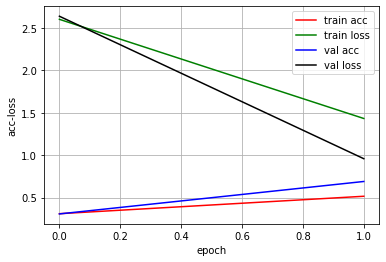

2020-04-12 06:56:47,217 INFO Training fold 2 completed. macro f1 score : 0.49026
2020-04-12 06:56:50,138 INFO Training completed. oof macro f1 score : 0.17661


,time,open_channels
0,500.000092,1
1,500.000214,1
2,500.000305,0
3,500.000397,0
4,500.000488,0


2020-04-12 06:56:57,538 INFO Training completed ...
2020-04-12 06:56:57,541 INFO [Running Wavenet model] done in 110 s


In [32]:
run_everything(fe_config)